# Predicting Patient Charges with Gradient Boosting Classification
**Author: May Cooper**

## Overview

This project builds an optimized gradient boosting classifier to predict binary outcomes based on patient healthcare data. The model identifies key drivers of classification performance, evaluates predictive accuracy, and visualizes feature importance and ROC-AUC to assess its practical utility in a healthcare context.

Research question: To what extent can features such as vitamin D levels, total medical charges, and their interaction contribute to accurately predicting patient readmissions within 30 days, using Gradient Boosting as the primary classification approach?

In [ ]:
import pandas as pd
import numpy as np

# dataset
file_path = 'medical_clean.csv'
data = pd.read_csv(file_path)

# the columns we need
kept_columns = ['ReAdmis', 'VitD_levels', 'TotalCharge']
print(f"- Keeping only these columns: {kept_columns}")
data = data[kept_columns]

# dropping rows with missing values
print("- Dropping rows with missing values.")
data.dropna(inplace=True)

# Creating VitD_TotalCharge_Interaction
print("- Creating an interaction feature: [VitD_levels * TotalCharge]")
data['VitD_TotalCharge_Interaction'] = data['VitD_levels'] * data['TotalCharge']

# Encoding target variable: 'ReAdmis' to: (Yes=1, No=0)
print("- Encoding 'ReAdmis' column to binary (Yes=1, No=0).")
data['ReAdmis'] = data['ReAdmis'].map({'Yes': 1, 'No': 0})

# Separating features (X) and target (y)
feature_columns = ['VitD_levels', 'TotalCharge', 'VitD_TotalCharge_Interaction']
target_column = 'ReAdmis'

X = data[feature_columns]
y = data[target_column]

# Combining features and target var into clean df without scaling
print("- Creating new Dataframe with features and target variable (no scaling).")
cleaned_columns = feature_columns + [target_column]
cleaned_data = pd.DataFrame(
    np.column_stack((X, y)),
    columns=cleaned_columns
)

- Keeping only these columns: ['ReAdmis', 'VitD_levels', 'TotalCharge']
- Dropping rows with missing values.
- Creating an interaction feature: [VitD_levels * TotalCharge]
- Encoding 'ReAdmis' column to binary (Yes=1, No=0).
- Creating new Dataframe with features and target variable (no scaling).


In [2]:
# Saving cleaned dataset to csv
output_file = 'cleaned_medical_data.csv'
print(f"Saving the cleaned dataset to {output_file}")
cleaned_data.to_csv(output_file, index=False)

Saving the cleaned dataset to cleaned_medical_data.csv


#### Splitting the cleaned data into training and test sets


In [3]:
from sklearn.model_selection import train_test_split

# Loading preprocessed data
cleaned_data = pd.read_csv('cleaned_medical_data.csv')

# Separatng features (X) and target (y)
X = cleaned_data[['VitD_levels', 'TotalCharge', 'VitD_TotalCharge_Interaction']]
y = cleaned_data['ReAdmis']

# Splitting data: retaining 80% for training, 20% testing
print("Splitting the data into training and test sets...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Saving splits to CSV files
train_file = 'train_data.csv'
test_file = 'test_data.csv'

print(f"Saving training data to '{train_file}' and test data to '{test_file}'...")
pd.concat([X_train, y_train], axis=1).to_csv(train_file, index=False)
pd.concat([X_test, y_test], axis=1).to_csv(test_file, index=False)

# Summary of the split
print("Data successfully split:")
print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")

Splitting the data into training and test sets...
Saving training data to 'train_data.csv' and test data to 'test_data.csv'...
Data successfully split:
Training set shape: (8000, 3), Test set shape: (2000, 3)


Creating an Initial Model, Evaluate with Classification Metrics

In [4]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)

# Initializing and training the model
print("Training Gradient Boosting Classifier...")
model = GradientBoostingClassifier(random_state=42)
model.fit(X_train, y_train)

# Creating predictions
print("Creating predictions on the test set...")
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

# Compute metrics using loops
print("Computing performance metrics...")
metrics_functions = {
    "Accuracy": accuracy_score,
    "Precision": precision_score,
    "Recall": recall_score,
    "F1 Score": f1_score,
    "AUC-ROC": roc_auc_score
}

metrics_results = {name: func(y_test, y_pred_proba if name == "AUC-ROC" else y_pred)
                   for name, func in metrics_functions.items()}

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

from tabulate import tabulate

print("Initial Model Metrics on the Test Set:")

# Creating table for metrics
metrics_table = [
    ["Accuracy", f"{metrics_results['Accuracy']:.4f}"],
    ["Precision", f"{metrics_results['Precision']:.4f}"],
    ["Recall", f"{metrics_results['Recall']:.4f}"],
    ["F1 Score", f"{metrics_results['F1 Score']:.4f}"],
    ["AUC-ROC", f"{metrics_results['AUC-ROC']:.4f}"]
]

# Printing metrics table
print(tabulate(metrics_table, headers=["Metric", "Value"], tablefmt="pretty"))

# Displaying confusion matrix
print("\nConfusion Matrix:")
print(tabulate(cm, tablefmt="grid"))

Training Gradient Boosting Classifier...
Creating predictions on the test set...
Computing performance metrics...
Initial Model Metrics on the Test Set:
+-----------+--------+
|  Metric   | Value  |
+-----------+--------+
| Accuracy  | 0.9535 |
| Precision | 0.9190 |
|  Recall   | 0.9578 |
| F1 Score  | 0.9380 |
|  AUC-ROC  | 0.9925 |
+-----------+--------+

Confusion Matrix:
+------+-----+
| 1204 |  62 |
+------+-----+
|   31 | 703 |
+------+-----+


##### Randomized Search CV

In [5]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import uniform, randint

# Defining parameter distributions
param_distributions = {
    'n_estimators': randint(50, 300),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10)
}

# Initializing base model
gboost_clf = GradientBoostingClassifier(random_state=42)

# Defining stratified k-fold CV
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Executing Randomized Search CV
random_search = RandomizedSearchCV(
    estimator=gboost_clf,
    param_distributions=param_distributions,
    scoring='accuracy',
    n_iter=50,
    cv=cv_strategy,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fitting RandomizedSearchCV on training data
random_search.fit(X_train, y_train)

# results
print("\nHyperparameter Tuning Complete.")
print("Best hyperparameters:", random_search.best_params_)
print(f"Best CV Score ({random_search.scoring}): {random_search.best_score_:.4f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits

Hyperparameter Tuning Complete.
Best hyperparameters: {'learning_rate': np.float64(0.02692347370813008), 'max_depth': 6, 'n_estimators': 207}
Best CV Score (accuracy): 0.9527


Use the best estimator from E3 to make predictions on the test set and show classification metrics.

In [6]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)
from tabulate import tabulate

# optimized model from RandomizedSearchCV
optimized_model = random_search.best_estimator_

# predictions on the test set
y_pred_optimized = optimized_model.predict(X_test)
y_pred_proba_optimized = optimized_model.predict_proba(X_test)[:, 1]

# Compute classification metrics
metrics_functions = {
    "Accuracy": accuracy_score,
    "Precision": precision_score,
    "Recall": recall_score,
    "F1 Score": f1_score,
    "AUC-ROC": roc_auc_score
}

metrics_results = {
    name: func(y_test, y_pred_proba_optimized if name == "AUC-ROC" else y_pred_optimized)
    for name, func in metrics_functions.items()
}

# Confusion matrix
cm_opt = confusion_matrix(y_test, y_pred_optimized)

# results
print("Optimized Gradient Boosting Model Metrics on the Test Set:")

# Metrics Table
metrics_table = [
    ["Accuracy", f"{metrics_results['Accuracy']:.4f}"],
    ["Precision", f"{metrics_results['Precision']:.4f}"],
    ["Recall", f"{metrics_results['Recall']:.4f}"],
    ["F1 Score", f"{metrics_results['F1 Score']:.4f}"],
    ["AUC-ROC", f"{metrics_results['AUC-ROC']:.4f}"]
]

print(tabulate(metrics_table, headers=["Metric", "Value"], tablefmt="pretty"))

# Confusion Matrix
print("\nConfusion Matrix:")
print(tabulate(cm_opt, tablefmt="grid"))

Optimized Gradient Boosting Model Metrics on the Test Set:
+-----------+--------+
|  Metric   | Value  |
+-----------+--------+
| Accuracy  | 0.9460 |
| Precision | 0.9097 |
|  Recall   | 0.9469 |
| F1 Score  | 0.9279 |
|  AUC-ROC  | 0.9920 |
+-----------+--------+

Confusion Matrix:
+------+-----+
| 1197 |  69 |
+------+-----+
|   39 | 695 |
+------+-----+


### Plotting

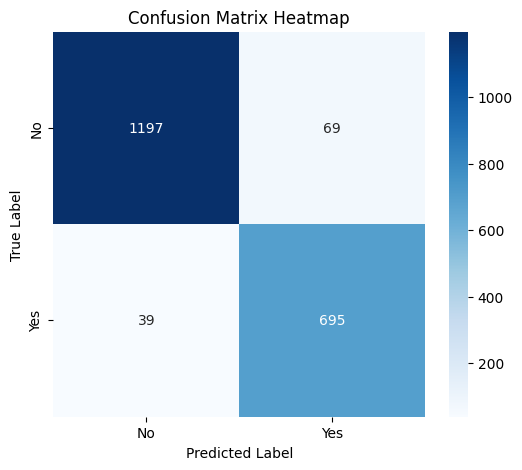

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# confusion matrix
cm = confusion_matrix(y_test, y_pred_optimized)

# heatmap for confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

C:\Users\MayCooperStation\AppData\Local\Temp\ipykernel_15864\2073079303.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')


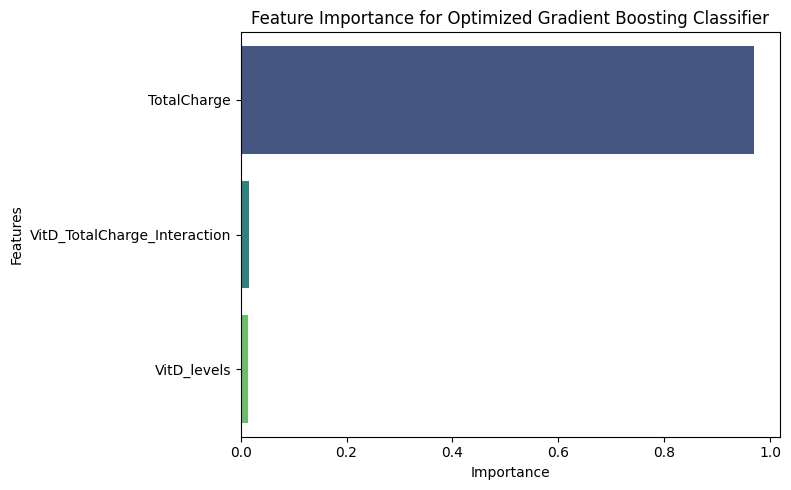

In [8]:
# Feature importance plotting
feature_importances = optimized_model.feature_importances_
features = ['VitD_levels', 'TotalCharge', 'VitD_TotalCharge_Interaction']

# making df for plotting
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by="Importance", ascending=False)

# Plotting feature importances
plt.figure(figsize=(8, 5))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title("Feature Importance for Optimized Gradient Boosting Classifier")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

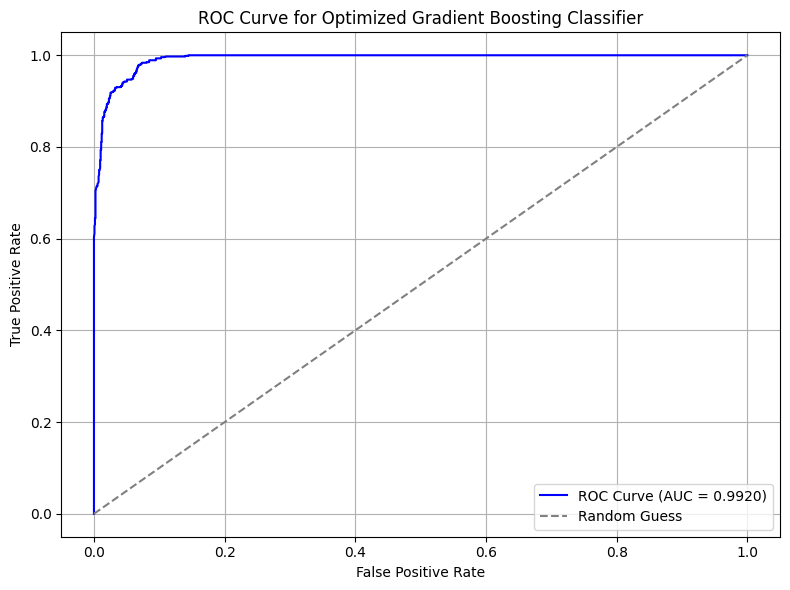

In [9]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_optimized)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Random Guess")
plt.title("ROC Curve for Optimized Gradient Boosting Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()